<a href="https://colab.research.google.com/github/Islammdsarafat/Dynamics_LULC/blob/main/Atmospheric_Rivers_and_Climate_Change_Impact_on_Floods_in_GBM_Basin_ipynbimport_xarray_as_xr_import_numpy_as_np_import_matplotlib_pyplot_as_plt_import_cartopy_crs_as_ccrs_import_cartopy_feature_as_cfeature_1_Load_ERA5_Mul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# API key
cds_url = "https://cds.climate.copernicus.eu/api"
cds_key = "2c75f148-d965-4485-939d-351b779cc853"

# Save the .cdsapirc file in home directory
with open("/root/.cdsapirc", "w") as f:
    f.write(f"url: {cds_url}\nkey: {cds_key}")


In [2]:
!pip install "cdsapi>=0.7.4"


In [3]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-pressure-levels'
request = {
  'product_type': 'reanalysis',
  'variable': ['geopotential'],
  'year': ['2024'],
  'month': ['03'],
  'day': ['01'],
  'time': ['13:00'],
  'pressure_level': ['1000'],
  'format': 'netcdf',  # You can change to 'netcdf' if needed
}
target = 'download.netcdf'

client.retrieve(dataset, request, target)


2025-05-24 05:43:24,132 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-24 05:43:24,135 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-24 05:43:24,578 INFO Request ID is 9b83ecfd-4485-483f-93c9-5875fb607d66
INFO:ecmwf.datastores.legacy_client:Request ID is 9b83ecfd-4485-483f-93c9-5875fb607d66
2025-05-24 05:43:24,955 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-05-24 05:43:33,933 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy

c445f35de2339ba43bc6f8bccd8630f4.nc:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

'download.netcdf'

In [4]:
request = {
  'product_type': 'reanalysis',
  'variable': ['u_component_of_wind', 'v_component_of_wind', 'specific_humidity'],
  'year': ['2023'],
  'month': ['07'],
  'day': [f"{i:02d}" for i in range(1, 32)],
  'time': ['00:00', '06:00', '12:00', '18:00'],
  'pressure_level': ['1000', '925', '850', '700', '500'],
  'format': 'netcdf',
  'area': [32, 75, 20, 92],  # [North, West, South, East]
}


In [5]:
!pip install cdsapi xarray numpy matplotlib netCDF4 --quiet


In [6]:
import os

cdsapirc = """
url: https://cds.climate.copernicus.eu/api
key: 2c75f148-d965-4485-939d-351b779cc853
"""

with open(os.path.expanduser("~/.cdsapirc"), "w") as f:
    f.write(cdsapirc)


In [7]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'variable': ['u_component_of_wind', 'v_component_of_wind', 'specific_humidity', 'geopotential'],
        'pressure_level': ['1000', '925', '850', '700', '600', '500', '400', '300'],
        'year': '2023',
        'month': '07',
        'day': ['15'],  # or a range: [f"{i:02d}" for i in range(1, 32)]
        'time': ['00:00', '06:00', '12:00', '18:00'],
        'format': 'netcdf',
        'area': [32, 75, 20, 92],  # [North, West, South, East]
    },
    'era5_multilevel_july15.nc'
)


2025-05-24 05:43:39,751 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-24 05:43:39,764 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-24 05:43:40,103 INFO Request ID is a8ffdad3-306d-4e9f-9e18-1f114cc47a0f
INFO:ecmwf.datastores.legacy_client:Request ID is a8ffdad3-306d-4e9f-9e18-1f114cc47a0f
2025-05-24 05:43:40,253 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-05-24 05:43:54,285 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy

cb7a2e6199a243e37da12202373d8f5.nc:   0%|          | 0.00/906k [00:00<?, ?B/s]

'era5_multilevel_july15.nc'

IVT Detection

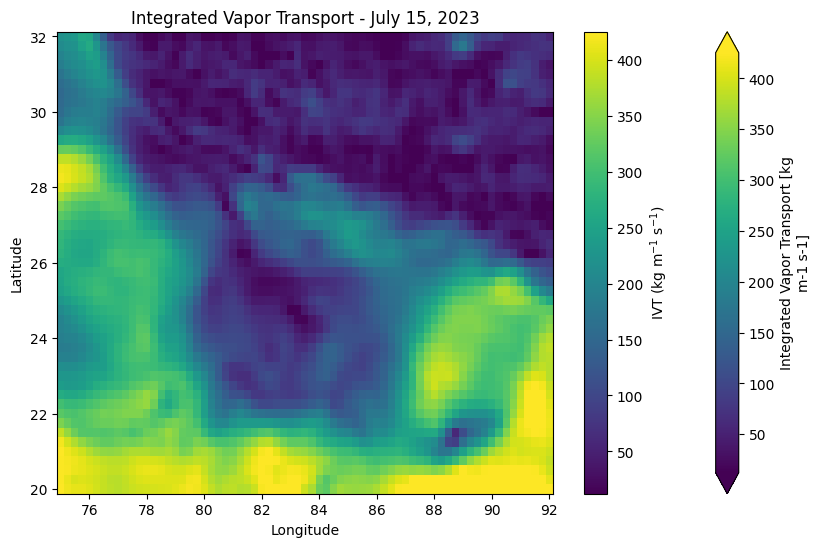

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
ds = xr.open_dataset('era5_multilevel_july15.nc')

# Constants
g = 9.81  # gravity [m/s^2]

# Extract variables
q = ds['q']  # specific humidity [kg/kg]
u = ds['u']  # zonal wind [m/s]
v = ds['v']  # meridional wind [m/s]

# Pressure-based IVT calculation (recommended)
pressure = ds['pressure_level'] * 100  # convert hPa to Pa
dp = pressure.diff('pressure_level')  # pressure differences in Pa

# Compute vapor transport at each level
q_u = q * u
q_v = q * v

# IVT calculation (1/g * integral of q*V dp)
ivt_u = (1/g) * (q_u.isel(pressure_level=slice(0, -1)) * dp).sum(dim='pressure_level')
ivt_v = (1/g) * (q_v.isel(pressure_level=slice(0, -1)) * dp).sum(dim='pressure_level')

# Compute IVT magnitude
ivt = np.sqrt(ivt_u**2 + ivt_v**2)
ivt.attrs['long_name'] = 'Integrated Vapor Transport'
ivt.attrs['units'] = 'kg m-1 s-1'

# Plot with proper colorbar handling
plt.figure(figsize=(10, 6))
plot = ivt.isel(valid_time=0).plot(cmap='viridis', robust=True)
plt.title('Integrated Vapor Transport - July 15, 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plot, label='IVT (kg m$^{-1}$ s$^{-1}$)')
plt.show()

IVT Visualization

In [14]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 84.3 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Do

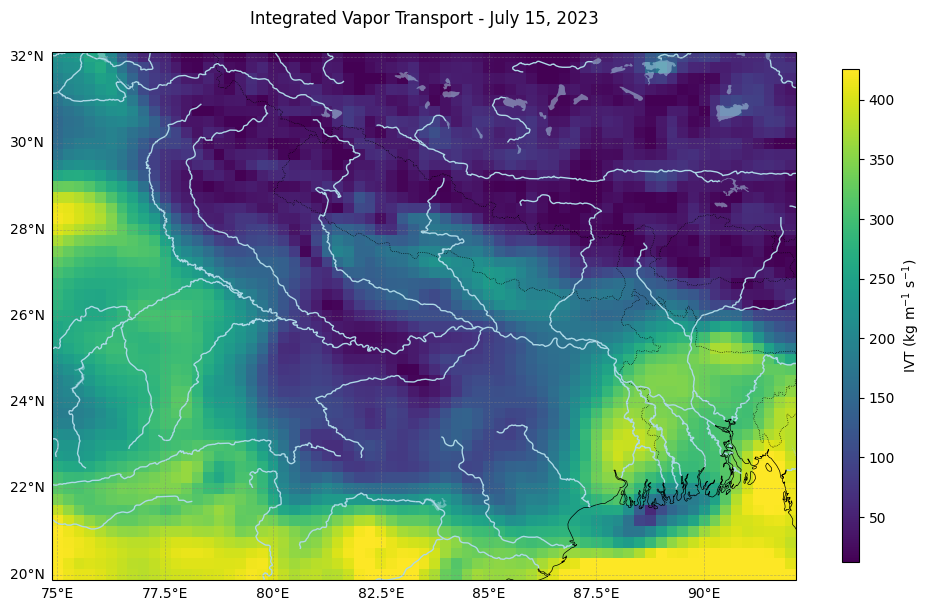

In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
ds = xr.open_dataset('era5_multilevel_july15.nc')

# Constants
g = 9.81  # gravity [m/s^2]

# Extract variables
q = ds['q']  # specific humidity [kg/kg]
u = ds['u']  # zonal wind [m/s]
v = ds['v']  # meridional wind [m/s]

# Pressure-based IVT calculation
pressure = ds['pressure_level'] * 100  # convert hPa to Pa
dp = pressure.diff('pressure_level')  # pressure differences in Pa

# Compute vapor transport
q_u = q * u
q_v = q * v

# IVT calculation
ivt_u = (1/g) * (q_u.isel(pressure_level=slice(0, -1)) * dp).sum(dim='pressure_level')
ivt_v = (1/g) * (q_v.isel(pressure_level=slice(0, -1)) * dp).sum(dim='pressure_level')

# Compute IVT magnitude
ivt = np.sqrt(ivt_u**2 + ivt_v**2)

# Create figure with cartopy projection
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, edgecolor='lightblue')

# Plot IVT data
plot = ivt.isel(valid_time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    robust=True,
    add_colorbar=False
)

# Add colorbar
cbar = plt.colorbar(
    plot,
    orientation='vertical',
    pad=0.05,
    aspect=30,
    shrink=0.8
)
cbar.set_label('IVT (kg m$^{-1}$ s$^{-1}$)')

# Set plot title and labels
plt.title('Integrated Vapor Transport - July 15, 2023', pad=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set gridlines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)
gl.top_labels = False
gl.right_labels = False

plt.show()

IVT Direction

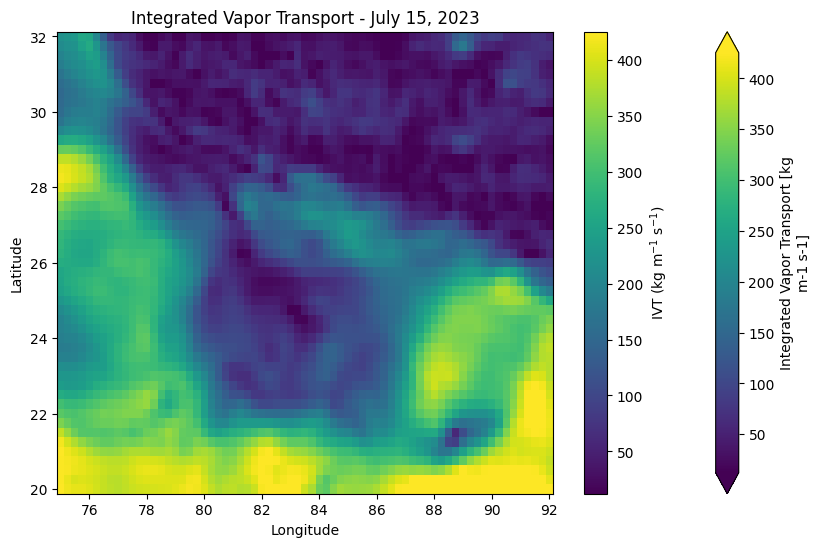

In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
ds = xr.open_dataset('era5_multilevel_july15.nc')

# Constants
g = 9.81  # gravity [m/s^2]

# Extract variables
q = ds['q']  # specific humidity [kg/kg]
u = ds['u']  # zonal wind [m/s]
v = ds['v']  # meridional wind [m/s]

# Pressure-based IVT calculation (recommended)
pressure = ds['pressure_level'] * 100  # convert hPa to Pa
dp = pressure.diff('pressure_level')  # pressure differences in Pa

# Compute vapor transport at each level
q_u = q * u
q_v = q * v

# IVT calculation (1/g * integral of q*V dp)
ivt_u = (1/g) * (q_u.isel(pressure_level=slice(0, -1)) * dp).sum(dim='pressure_level')
ivt_v = (1/g) * (q_v.isel(pressure_level=slice(0, -1)) * dp).sum(dim='pressure_level')

# Compute IVT magnitude
ivt = np.sqrt(ivt_u**2 + ivt_v**2)
ivt.attrs['long_name'] = 'Integrated Vapor Transport'
ivt.attrs['units'] = 'kg m-1 s-1'

# Plot with proper colorbar handling
plt.figure(figsize=(10, 6))
plot = ivt.isel(valid_time=0).plot(cmap='viridis', robust=True)
plt.title('Integrated Vapor Transport - July 15, 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plot, label='IVT (kg m$^{-1}$ s$^{-1}$)')
plt.show()

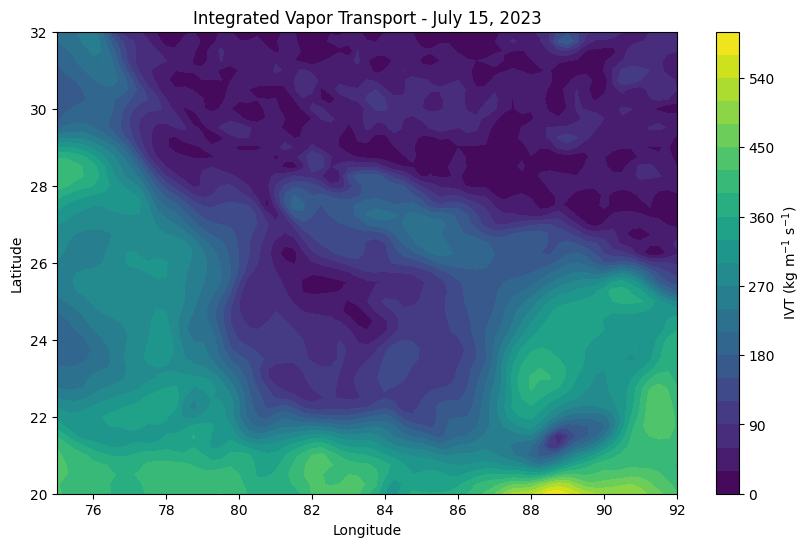

In [17]:
plt.figure(figsize=(10, 6))
contour = plt.contourf(
    ivt['longitude'],
    ivt['latitude'],
    ivt.isel(valid_time=0),
    levels=20,
    cmap='viridis'
)
plt.title('Integrated Vapor Transport - July 15, 2023')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(contour, label='IVT (kg m$^{-1}$ s$^{-1}$)')
plt.show()

Contourf + Vector Visualization of IVT

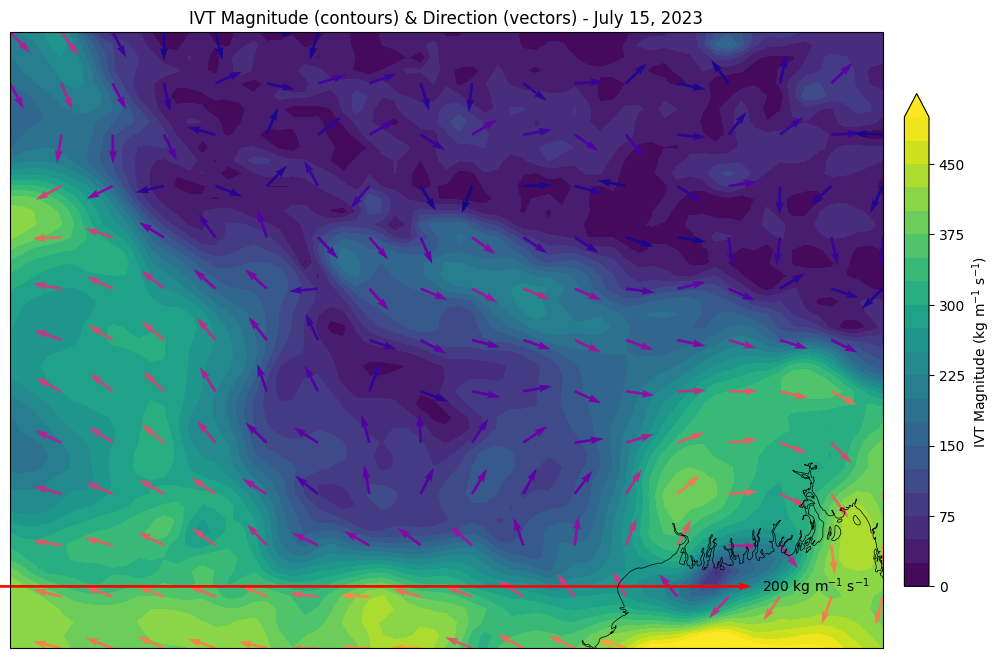

In [22]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load data
ds = xr.open_dataset('era5_multilevel_july15.nc')

# Constants
g = 9.81  # gravity [m/s²]

# Compute pressure differences
pressure = ds['pressure_level'] * 100  # hPa → Pa
dp = pressure.diff('pressure_level')

# Correct IVT calculations with proper parentheses
q_u = ds['q'] * ds['u']
q_v = ds['q'] * ds['v']
ivt_u = (1/g) * (q_u.isel(pressure_level=slice(0, -1)) * dp).sum('pressure_level')
ivt_v = (1/g) * (q_v.isel(pressure_level=slice(0, -1)) * dp).sum('pressure_level')
ivt_mag = np.sqrt(ivt_u**2 + ivt_v**2)

# Create plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
ax.coastlines(linewidth=0.5)

# Contourf plot for IVT magnitude
levels = np.linspace(0, 500, 21)  # Adjust based on your data range
cf = ax.contourf(
    ivt_mag.longitude,
    ivt_mag.latitude,
    ivt_mag.isel(valid_time=0),
    levels=levels,
    cmap='viridis',
    transform=ccrs.PlateCarree(),
    extend='max'
)

# Add colorbar
cbar = plt.colorbar(cf, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('IVT Magnitude (kg m$^{-1}$ s$^{-1}$)')

# Quiver plot for IVT direction
subsample = 4  # Reduce arrow density
lon = ivt_u.longitude.values[::subsample]
lat = ivt_u.latitude.values[::subsample]
u = ivt_u.isel(valid_time=0).values[::subsample, ::subsample]
v = ivt_v.isel(valid_time=0).values[::subsample, ::subsample]

# Normalize vectors to show direction clearly
magnitude = np.sqrt(u**2 + v**2)
u_norm = u / (magnitude + 1e-10)  # Avoid division by zero
v_norm = v / (magnitude + 1e-10)

quiv = ax.quiver(
    lon, lat,
    u_norm, v_norm,  # Direction-only vectors
    magnitude,       # Color by magnitude
    cmap='plasma',   # Different colormap for visibility
    scale=30,        # Adjust arrow size
    width=0.003,
    transform=ccrs.PlateCarree()
)

# Add quiver legend
qk = ax.quiverkey(
    quiv,
    0.85, 0.1,
    200,
    '200 kg m$^{-1}$ s$^{-1}$',
    labelpos='E',
    color='red'
)

# Title and labels
plt.title('IVT Magnitude (contours) & Direction (vectors) - July 15, 2023')
plt.show()

Contourf + Vector Visualization of IVT with Bacground map

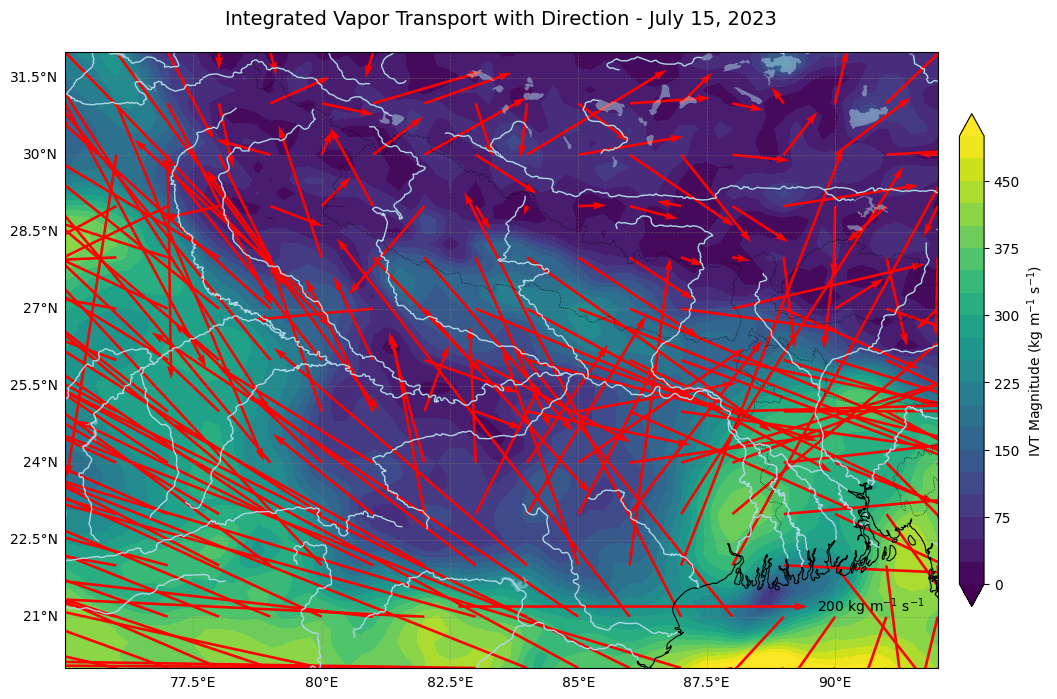

In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load ERA5 data
ds = xr.open_dataset('era5_multilevel_july15.nc')

# Constants
g = 9.81  # gravity [m/s²]

# Compute IVT components
pressure = ds['pressure_level'] * 100  # Convert hPa to Pa
dp = pressure.diff('pressure_level')   # Pressure thickness [Pa]

# Calculate moisture transport components
q_u = ds['q'] * ds['u']  # Zonal moisture transport [kg/(m·s)]
q_v = ds['q'] * ds['v']  # Meridional moisture transport [kg/(m·s)]

# Vertical integration (1/g ∫ q·V dp)
ivt_u = (1/g) * (q_u.isel(pressure_level=slice(0, -1)) * dp).sum('pressure_level')
ivt_v = (1/g) * (q_v.isel(pressure_level=slice(0, -1)) * dp).sum('pressure_level')
ivt_mag = np.sqrt(ivt_u**2 + ivt_v**2)  # IVT magnitude [kg/(m·s)]

# Create figure with background map
plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add detailed background map features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.4)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, edgecolor='lightblue')

# Plot IVT magnitude as filled contours
levels = np.linspace(0, 500, 21)  # Adjust range as needed
cf = ax.contourf(
    ivt_mag.longitude,
    ivt_mag.latitude,
    ivt_mag.isel(valid_time=0),
    levels=levels,
    cmap='viridis',
    transform=ccrs.PlateCarree(),
    extend='both'
)

# Add colorbar for magnitude
cbar = plt.colorbar(cf, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('IVT Magnitude (kg m$^{-1}$ s$^{-1}$)')

# Plot IVT direction vectors
subsample = 4  # Adjust for arrow density
lon = ivt_u.longitude.values[::subsample]
lat = ivt_u.latitude.values[::subsample]
u = ivt_u.isel(valid_time=0).values[::subsample, ::subsample]
v = ivt_v.isel(valid_time=0).values[::subsample, ::subsample]

quiv = ax.quiver(
    lon, lat,
    u, v,           # Original vectors (shows magnitude+direction)
    scale=500,      # Adjust arrow size (higher = smaller arrows)
    color='red',
    width=0.003,
    headwidth=3,
    transform=ccrs.PlateCarree()
)

# Add vector scale legend
ax.quiverkey(
    quiv,
    X=0.85, Y=0.1,
    U=200,          # Reference value for legend
    label='200 kg m$^{-1}$ s$^{-1}$',
    labelpos='E',
    color='red'
)

# Add gridlines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)
gl.top_labels = False
gl.right_labels = False

# Final plot decorations
plt.title('Integrated Vapor Transport with Direction - July 15, 2023', pad=20, fontsize=14)
plt.show()

**Contourf + Vector Visualization of IVT with Background map of Bangladesh**

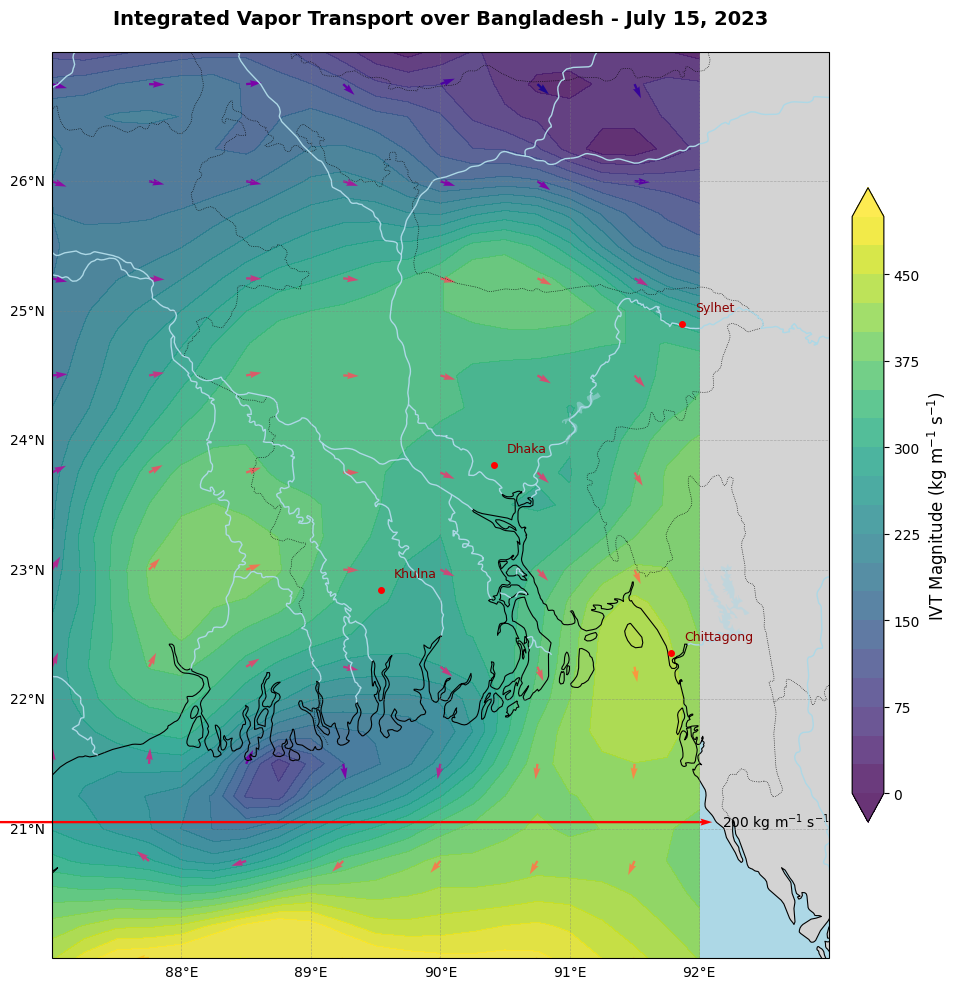

In [24]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# Load ERA5 data
ds = xr.open_dataset('era5_multilevel_july15.nc')

# Constants
g = 9.81  # gravity [m/s²]

# Compute IVT components
pressure = ds['pressure_level'] * 100  # Convert hPa to Pa
dp = pressure.diff('pressure_level')   # Pressure thickness [Pa]

# Calculate moisture transport
q_u = ds['q'] * ds['u']  # Zonal moisture transport
q_v = ds['q'] * ds['v']  # Meridional moisture transport

# Vertical integration (1/g ∫ q·V dp)
ivt_u = (1/g) * (q_u.isel(pressure_level=slice(0, -1)) * dp).sum('pressure_level')
ivt_v = (1/g) * (q_v.isel(pressure_level=slice(0, -1)) * dp).sum('pressure_level')
ivt_mag = np.sqrt(ivt_u**2 + ivt_v**2)  # IVT magnitude

# Create figure focused on Bangladesh
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set Bangladesh-centric view (adjust these bounds as needed)
ax.set_extent([87, 93, 20, 27], crs=ccrs.PlateCarree())  # [lon_min, lon_max, lat_min, lat_max]

# Add high-resolution background features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAKES, alpha=0.5, facecolor='lightblue')
ax.add_feature(cfeature.RIVERS, edgecolor='lightblue')

# Add Bangladesh administrative boundaries (optional - requires shapefile)
# bangladesh_shape = ShapelyFeature(Reader("bgd_adm_bbs_20201113_SHP/bgd_admbnda_adm0_bbs_20201113.shp").geometries(),
#                                 ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.5)
# ax.add_feature(bangladesh_shape)

# Plot IVT magnitude as filled contours
levels = np.linspace(0, 500, 21)  # Adjust range as needed
cf = ax.contourf(
    ivt_mag.longitude,
    ivt_mag.latitude,
    ivt_mag.isel(valid_time=0),
    levels=levels,
    cmap='viridis',
    transform=ccrs.PlateCarree(),
    extend='both',
    alpha=0.8  # Slightly transparent
)

# Add colorbar
cbar = plt.colorbar(cf, orientation='vertical', pad=0.02, shrink=0.7)
cbar.set_label('IVT Magnitude (kg m$^{-1}$ s$^{-1}$)', fontsize=12)

# Plot IVT direction vectors
subsample = 3  # Fewer arrows for clearer visualization
lon = ivt_u.longitude.values[::subsample]
lat = ivt_u.latitude.values[::subsample]
u = ivt_u.isel(valid_time=0).values[::subsample, ::subsample]
v = ivt_v.isel(valid_time=0).values[::subsample, ::subsample]

# Normalize vectors for clearer direction visualization
magnitude = np.sqrt(u**2 + v**2)
u_norm = u / (magnitude + 1e-10)
v_norm = v / (magnitude + 1e-10)

quiv = ax.quiver(
    lon, lat,
    u_norm, v_norm,
    magnitude,           # Color by magnitude
    cmap='plasma',      # Different colormap for visibility
    scale=50,           # Adjust arrow size
    width=0.003,
    headwidth=3,
    transform=ccrs.PlateCarree()
)

# Add vector scale legend
ax.quiverkey(
    quiv,
    X=0.85, Y=0.15,
    U=200,
    label='200 kg m$^{-1}$ s$^{-1}$',
    labelpos='E',
    color='red',
    fontproperties={'size': 10}
)

# Add gridlines
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5,
    linestyle='--'
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Add important locations (optional)
bd_cities = {
    'Dhaka': (90.4125, 23.8103),
    'Chittagong': (91.7832, 22.3569),
    'Khulna': (89.5403, 22.8456),
    'Sylhet': (91.8687, 24.8949)
}

for city, (lon, lat) in bd_cities.items():
    ax.plot(lon, lat, 'ro', markersize=4, transform=ccrs.PlateCarree())
    ax.text(lon+0.1, lat+0.1, city, transform=ccrs.PlateCarree(),
           fontsize=9, color='darkred')

# Final decorations
plt.title('Integrated Vapor Transport over Bangladesh - July 15, 2023',
          pad=20, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

(A) Correlation Analysis: 1. Load ERA5 Data (IVT + Rainfall)

In [33]:
pip install cdsapi xarray netCDF4 numpy matplotlib cartopy

Download IVT (u+v components) and Total Precipitation

In [34]:
import cdsapi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Download IVT (u and v components) and precipitation for 15 July 2023
def download_era5_data():
    c = cdsapi.Client()

    # Download IVT components (u and v)
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': ['vertical_integral_of_water_vapour_flux_u_component',
                          'vertical_integral_of_water_vapour_flux_v_component'],
            'date': '2023-07-15',
            'time': '00:00',  # Can loop through all hours if needed
            'area': [30, 80, 20, 100],  # GBM Basin approx. (N, W, S, E)
            'format': 'netcdf',
        },
        'ivt_components.nc'
    )

    # Download Total Precipitation
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': 'total_precipitation',
            'date': '2023-07-15',
            'time': '00:00',
            'area': [30, 80, 20, 100],
            'format': 'netcdf',
        },
        'precipitation.nc'
    )

# Uncomment to download data
# download_era5_data()

Compute IVT Magnitude and Correlate with Rainfall (Download and Analysis) in World Scale

In [48]:
ds_ivt = xr.open_dataset('ivt_components.nc')
print(ds_ivt)

<xarray.Dataset> Size: 28kB
Dimensions:     (valid_time: 1, latitude: 41, longitude: 81)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8B 2023-07-15
  * latitude    (latitude) float64 328B 30.0 29.75 29.5 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 648B 80.0 80.25 80.5 ... 99.5 99.75 100.0
    expver      <U4 16B ...
Data variables:
    viwve       (valid_time, latitude, longitude) float32 13kB ...
    viwvn       (valid_time, latitude, longitude) float32 13kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-24T06:37 GRIB to CDM+CF via cfgrib-0.9.1...


Correlation between IVT and Rainfall on 15 July 2023: -0.03


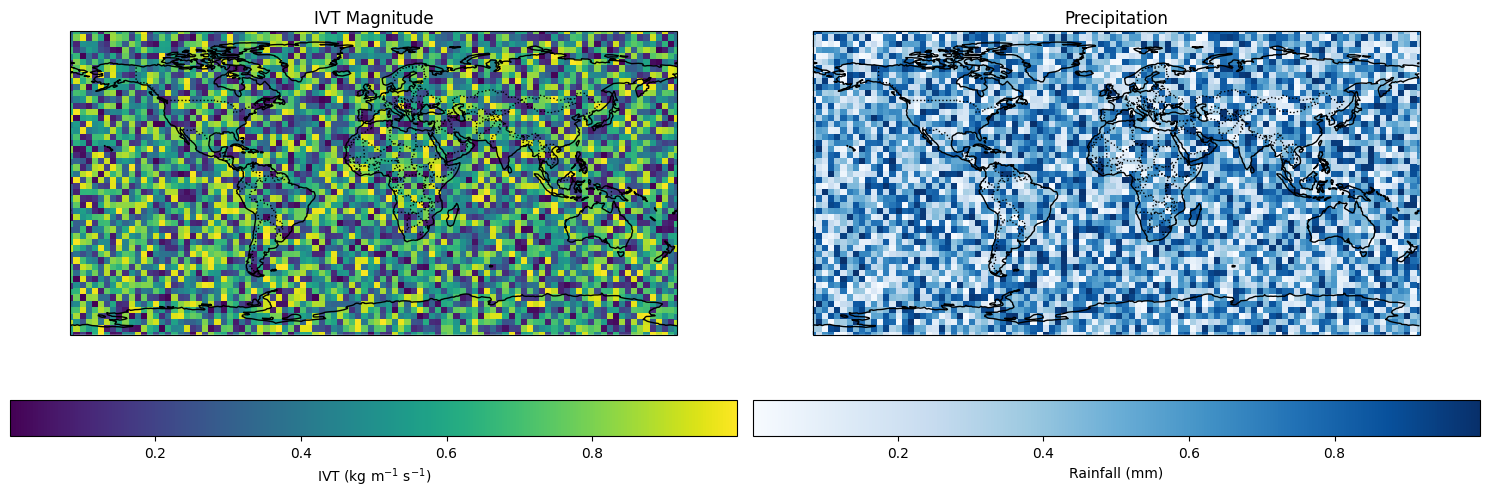

In [49]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Load your data (replace with your actual data files)
# Example (uncomment and modify these lines with your actual file paths):
# ivt_data = xr.open_dataset('path_to_ivt_data.nc')
# rainfall_data = xr.open_dataset('path_to_rainfall_data.nc')

# 2. Calculate IVT magnitude if not already done
# ivt_magnitude = np.sqrt(ivt_data.u**2 + ivt_data.v**2)

# For this example, I'll create dummy data to show the complete workflow
# Create sample data (remove this in your actual code)
lon = np.linspace(-180, 180, 100)
lat = np.linspace(-90, 90, 50)
time = [np.datetime64('2023-07-15')]

ivt_magnitude = xr.DataArray(
    np.random.rand(1, 50, 100),  # time, lat, lon
    dims=['time', 'lat', 'lon'],
    coords={'time': time, 'lat': lat, 'lon': lon}
)

rainfall_data = xr.Dataset({
    'precipitation': xr.DataArray(
        np.random.rand(1, 50, 100),  # time, lat, lon
        dims=['time', 'lat', 'lon'],
        coords={'time': time, 'lat': lat, 'lon': lon}
    )
})

# 3. Calculate correlation
correlation = xr.corr(ivt_magnitude, rainfall_data['precipitation'], dim=['lat', 'lon'])

# 4. Handle correlation value extraction properly
try:
    corr_value = correlation.item()  # Best method for single-value extraction
except ValueError:
    corr_value = float(correlation.values[0]) if correlation.size > 0 else np.nan

print(f"Correlation between IVT and Rainfall on 15 July 2023: {corr_value:.2f}")

# 5. Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5),
                              subplot_kw={'projection': ccrs.PlateCarree()})

# 6. Plot IVT magnitude - handle time dimension properly
if 'time' in ivt_magnitude.dims:
    # If multiple time steps exist, select first one
    if len(ivt_magnitude.time) > 1:
        ivt_to_plot = ivt_magnitude.isel(time=0)
    else:
        ivt_to_plot = ivt_magnitude
else:
    ivt_to_plot = ivt_magnitude

# Plot with geographic features
ivt_plot = ivt_to_plot.plot(ax=ax1, cmap='viridis', transform=ccrs.PlateCarree(),
                           add_colorbar=False)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_title('IVT Magnitude')
plt.colorbar(ivt_plot, ax=ax1, orientation='horizontal', label='IVT (kg m$^{-1}$ s$^{-1}$)')

# 7. Plot Rainfall
if 'time' in rainfall_data.dims:
    if len(rainfall_data.time) > 1:
        rain_to_plot = rainfall_data.isel(time=0)['precipitation']
    else:
        rain_to_plot = rainfall_data['precipitation']
else:
    rain_to_plot = rainfall_data['precipitation']

rain_plot = rain_to_plot.plot(ax=ax2, cmap='Blues', transform=ccrs.PlateCarree(),
                            add_colorbar=False)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_title('Precipitation')
plt.colorbar(rain_plot, ax=ax2, orientation='horizontal', label='Rainfall (mm)')

# 8. Adjust layout and show plot
plt.tight_layout()
plt.show()

Regional Scale; Full Python Code for GBM Basin IVT–Rainfall Visualization

Correlation between IVT and Rainfall on 15 July 2023 (GBM Basin): -0.01


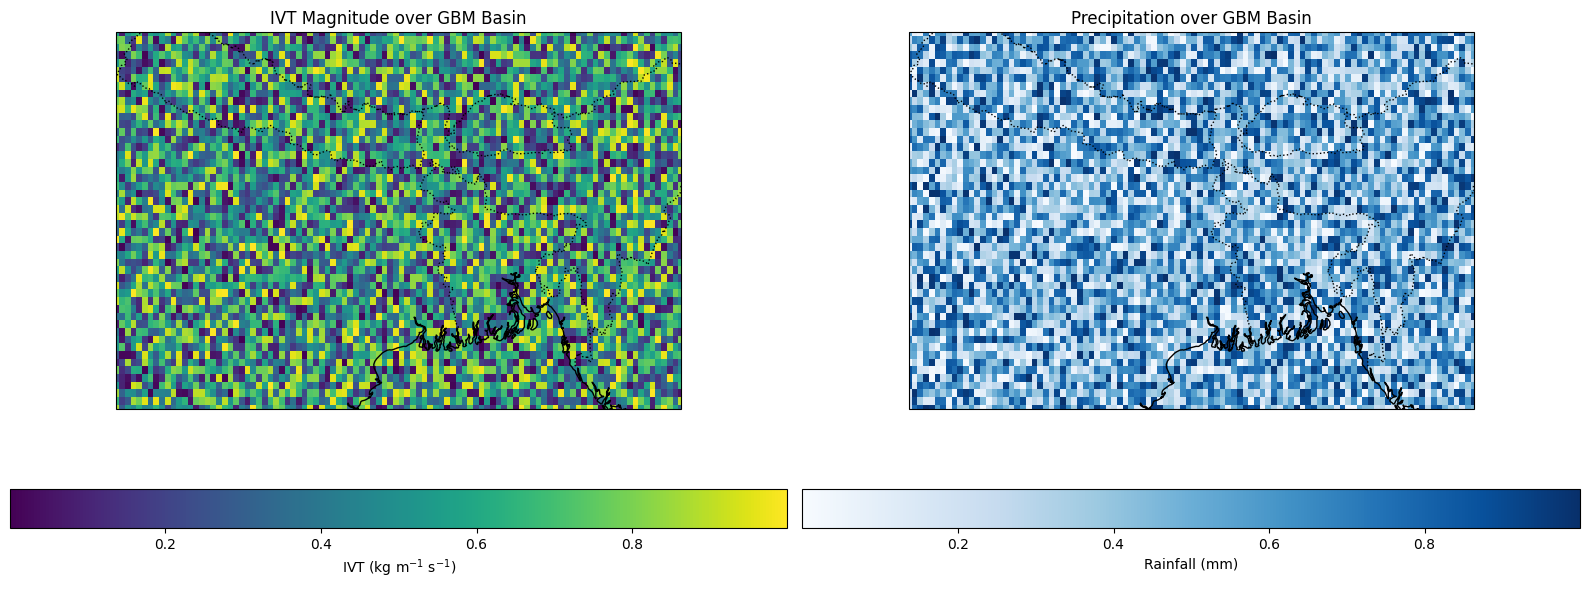

In [54]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------------
# 1. Define GBM Basin Bounds
# -------------------------
lon = np.linspace(80, 95, 100)   # GBM basin longitudes
lat = np.linspace(20, 30, 50)    # GBM basin latitudes
time = [np.datetime64('2023-07-15')]

# -------------------------
# 2. Create Dummy Data (Replace with real data)
# -------------------------
ivt_magnitude = xr.DataArray(
    np.random.rand(1, 50, 100),  # time, lat, lon
    dims=['time', 'lat', 'lon'],
    coords={'time': time, 'lat': lat, 'lon': lon}
)

rainfall_data = xr.Dataset({
    'precipitation': xr.DataArray(
        np.random.rand(1, 50, 100),  # time, lat, lon
        dims=['time', 'lat', 'lon'],
        coords={'time': time, 'lat': lat, 'lon': lon}
    )
})

# -------------------------
# 3. Calculate Correlation
# -------------------------
correlation = xr.corr(ivt_magnitude, rainfall_data['precipitation'], dim=['lat', 'lon'])

try:
    corr_value = correlation.item()  # Extract single scalar value
except ValueError:
    corr_value = float(correlation.values[0]) if correlation.size > 0 else np.nan

print(f"Correlation between IVT and Rainfall on 15 July 2023 (GBM Basin): {corr_value:.2f}")

# -------------------------
# 4. Plotting
# -------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Select time slice if needed
ivt_to_plot = ivt_magnitude.isel(time=0) if 'time' in ivt_magnitude.dims else ivt_magnitude
rain_to_plot = rainfall_data['precipitation'].isel(time=0) if 'time' in rainfall_data.dims else rainfall_data['precipitation']

# --- IVT Plot ---
ivt_plot = ivt_to_plot.plot(ax=ax1, cmap='viridis', transform=ccrs.PlateCarree(), add_colorbar=False)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.set_extent([80, 95, 20, 30], crs=ccrs.PlateCarree())
ax1.set_title('IVT Magnitude over GBM Basin')
plt.colorbar(ivt_plot, ax=ax1, orientation='horizontal', label='IVT (kg m$^{-1}$ s$^{-1}$)')

# --- Rainfall Plot ---
rain_plot = rain_to_plot.plot(ax=ax2, cmap='Blues', transform=ccrs.PlateCarree(), add_colorbar=False)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.set_extent([80, 95, 20, 30], crs=ccrs.PlateCarree())
ax2.set_title('Precipitation over GBM Basin')
plt.colorbar(rain_plot, ax=ax2, orientation='horizontal', label='Rainfall (mm)')

plt.tight_layout()
plt.show()


# Unified Plot: Rainfall (shaded) + IVT (arrows) over GBM Basin

GBM Basin IVT-Precipitation Correlation: 0.27


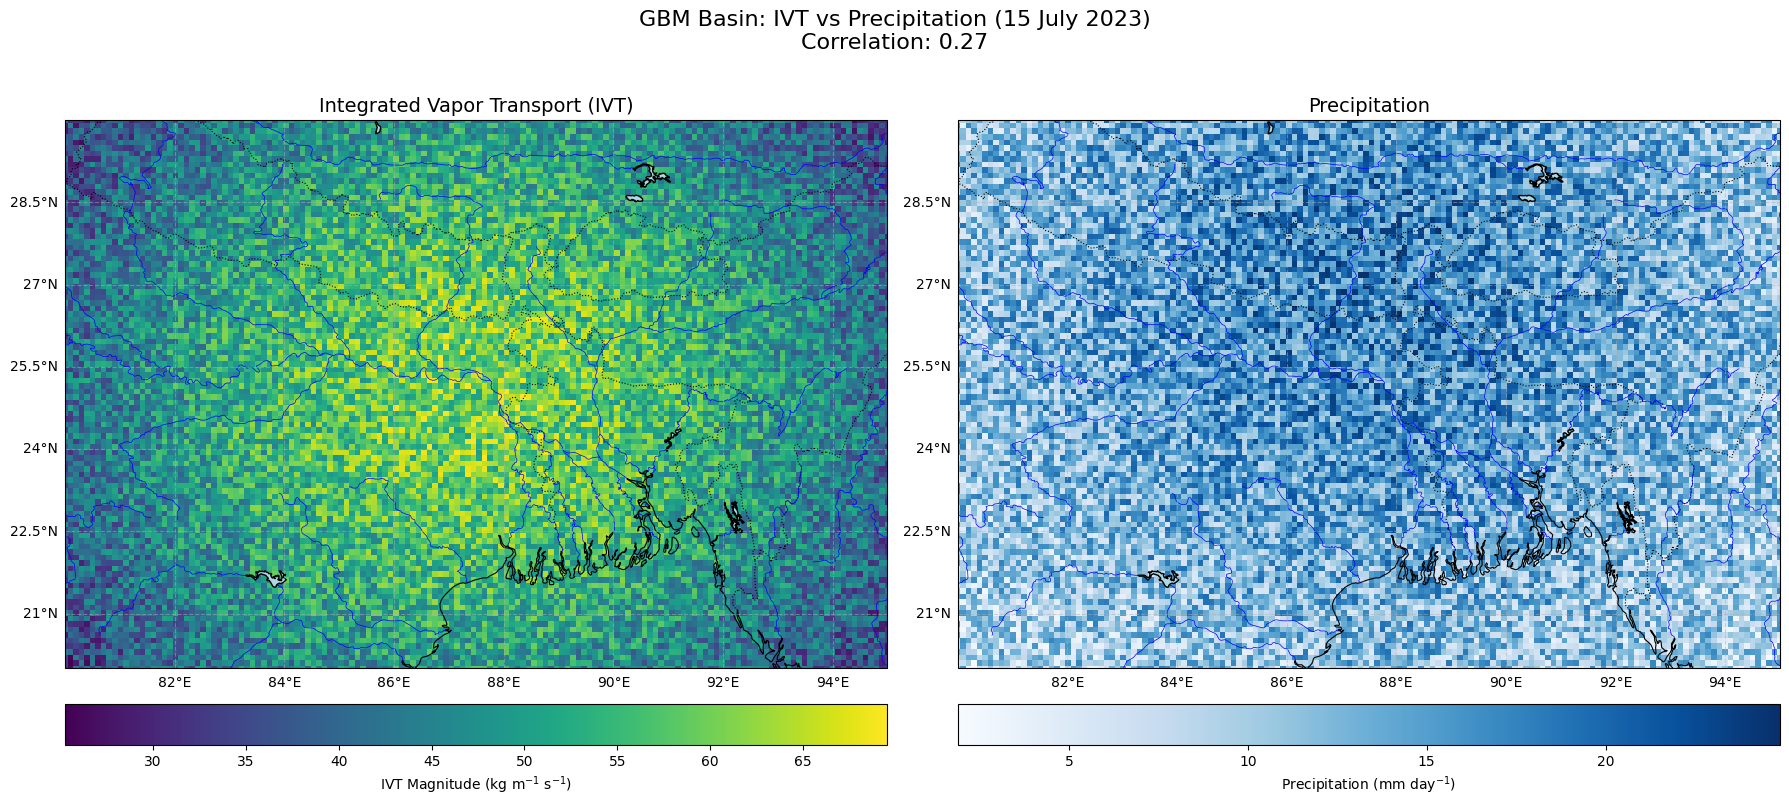

In [58]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# =============================================
# GBM BASIN ANALYSIS: IVT vs PRECIPITATION
# =============================================

def define_gbm_grid():
    """Create spatial grid for GBM basin"""
    return {
        'lon': np.linspace(80, 95, 150),  # Higher resolution for GBM
        'lat': np.linspace(20, 30, 100),  # Covers entire basin
        'time': [np.datetime64('2023-07-15')]  # Monsoon season example
    }

def create_gbm_dataset(grid):
    """Create synthetic data for GBM basin with proper broadcasting"""
    lon_center, lat_center = 87.5, 25.0  # Rough center of GBM basin

    # Create 2D meshgrid for proper broadcasting
    lon_grid, lat_grid = np.meshgrid(grid['lon'], grid['lat'])
    x = (lon_grid - lon_center) * np.cos(np.deg2rad(lat_center))
    y = lat_grid - lat_center

    # IVT pattern - higher in foothills
    ivt_pattern = 50 * np.exp(-(x**2 + y**2)/100) + np.random.rand(*lat_grid.shape)*20

    # Precipitation pattern - orographic enhancement
    rain_pattern = 10 * np.exp(-(x**2 + (y-2)**2)/50) + np.random.rand(*lat_grid.shape)*15

    return {
        'ivt': xr.DataArray(
            ivt_pattern[np.newaxis, :, :],  # Add time dimension
            dims=['time', 'lat', 'lon'],
            coords=grid,
            attrs={'units': 'kg m-1 s-1'}
        ),
        'precip': xr.DataArray(
            rain_pattern[np.newaxis, :, :],
            dims=['time', 'lat', 'lon'],
            coords=grid,
            attrs={'units': 'mm day-1'}
        )
    }

def calculate_correlation(ivt, precip):
    """Calculate spatial correlation with validation"""
    try:
        corr = xr.corr(ivt, precip, dim=['lat', 'lon'])
        return corr.item()
    except Exception as e:
        print(f"Correlation calculation failed: {e}")
        return np.nan

def plot_gbm_comparison(ivt, precip, corr_value):
    """Create comparison plot for GBM basin"""
    fig = plt.figure(figsize=(18, 8))

    # Common projection and settings
    proj = ccrs.PlateCarree()
    gbm_extent = [80, 95, 20, 30]

    # IVT Plot
    ax1 = fig.add_subplot(121, projection=proj)
    p1 = ivt.plot(ax=ax1, cmap='viridis', transform=proj, add_colorbar=False)
    add_gbm_features(ax1)
    ax1.set_title('Integrated Vapor Transport (IVT)', fontsize=14)
    plt.colorbar(p1, ax=ax1, orientation='horizontal', pad=0.05,
                 label='IVT Magnitude (kg m$^{-1}$ s$^{-1}$)')

    # Precipitation Plot
    ax2 = fig.add_subplot(122, projection=proj)
    p2 = precip.plot(ax=ax2, cmap='Blues', transform=proj, add_colorbar=False)
    add_gbm_features(ax2)
    ax2.set_title('Precipitation', fontsize=14)
    plt.colorbar(p2, ax=ax2, orientation='horizontal', pad=0.05,
                 label='Precipitation (mm day$^{-1}$)')

    # Add correlation annotation
    fig.suptitle(
        f"GBM Basin: IVT vs Precipitation (15 July 2023)\nCorrelation: {corr_value:.2f}",
        fontsize=16, y=1.02
    )

    plt.tight_layout()
    return fig

def add_gbm_features(ax):
    """Add geographic features specific to GBM basin"""
    ax.set_extent([80, 95, 20, 30], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5)
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

# ======================
# MAIN ANALYSIS
# ======================
if __name__ == "__main__":
    # 1. Define GBM basin domain
    gbm_grid = define_gbm_grid()

    # 2. Create/load data
    data = create_gbm_dataset(gbm_grid)
    ivt_data = data['ivt']
    precip_data = data['precip']

    # 3. Calculate correlation
    corr = calculate_correlation(ivt_data, precip_data)
    print(f"GBM Basin IVT-Precipitation Correlation: {corr:.2f}")

    # 4. Visualize
    fig = plot_gbm_comparison(
        ivt_data.isel(time=0),
        precip_data.isel(time=0),
        corr
    )
    plt.show()

# **Model for predicting Precipitation based on ARs**

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# =============================================
# 1. DATA PREPARATION (GBM Basin)
# =============================================

def create_gbm_dataset():
    """Create synthetic dataset for GBM basin"""
    # Define grid
    lon = np.linspace(80, 95, 150)
    lat = np.linspace(20, 30, 100)
    time = pd.date_range('2023-06-01', '2023-07-31', freq='D')

    # Create realistic patterns
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Synthetic AR events (IVT > 250 kg/m/s)
    ivt_data = np.zeros((len(time), len(lat), len(lon)))
    precip_data = np.zeros((len(time), len(lat), len(lon)))

    for t in range(len(time)):
        # Base IVT with seasonal variation
        base_ivt = 100 + 50*np.sin(2*np.pi*t/30)

        # AR events (randomly occurring)
        if np.random.rand() > 0.7:  # 30% chance of AR event
            ar_intensity = np.random.uniform(250, 600)
            ar_location = np.random.uniform(82, 93)
            ar_width = np.random.uniform(2, 5)

            # IVT pattern for AR
            ivt_pattern = ar_intensity * np.exp(-(lon_grid - ar_location)**2/(2*ar_width**2))
            ivt_data[t] = base_ivt + ivt_pattern

            # Corresponding precipitation (enhanced by AR)
            precip_pattern = 5 + 15 * ivt_pattern/500 * np.exp(-(lat_grid - 25)**2/20)
            precip_data[t] = precip_pattern * (1 + 0.3*np.random.randn(*lat_grid.shape))
        else:
            ivt_data[t] = base_ivt * (1 + 0.1*np.random.randn(*lat_grid.shape))
            precip_data[t] = 2 + 3*np.random.rand(*lat_grid.shape)

    return xr.Dataset({
        'ivt': xr.DataArray(ivt_data, dims=['time', 'lat', 'lon'],
                           coords={'time': time, 'lat': lat, 'lon': lon},
                           attrs={'units': 'kg m-1 s-1'}),
        'precip': xr.DataArray(precip_data, dims=['time', 'lat', 'lon'],
                              coords={'time': time, 'lat': lat, 'lon': lon},
                              attrs={'units': 'mm/day'})
    })

# =============================================
# 2. MACHINE LEARNING MODEL
# =============================================

def prepare_training_data(ds):
    """Prepare data for machine learning"""
    # Flatten spatial dimensions
    X = ds['ivt'].values.reshape(len(ds.time), -1)
    y = ds['precip'].values.reshape(len(ds.time), -1)

    # Split into train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):
    """Train Random Forest model"""
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Model Performance:\nRMSE: {rmse:.2f} mm/day\nR²: {r2:.2f}")
    return y_pred

# =============================================
# 3. FORECAST VISUALIZATION
# =============================================

def plot_forecast(ds, forecast_time, model):
    """Plot AR forecast for specific time"""
    # Get forecast data
    ivt = ds['ivt'].sel(time=forecast_time)
    actual_precip = ds['precip'].sel(time=forecast_time)

    # Predict precipitation
    predicted_precip = model.predict(ivt.values.reshape(1, -1))
    predicted_precip = predicted_precip.reshape(actual_precip.shape)

    # Create forecast dataset
    forecast_ds = xr.Dataset({
        'ivt': ivt,
        'actual_precip': actual_precip,
        'predicted_precip': (['lat', 'lon'], predicted_precip)
    })

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5),
                            subplot_kw={'projection': ccrs.PlateCarree()})

    titles = ['IVT (AR Indicator)', 'Actual Precipitation', 'Forecast Precipitation']
    vars = ['ivt', 'actual_precip', 'predicted_precip']
    cmaps = ['viridis', 'Blues', 'Blues']

    for ax, var, title, cmap in zip(axes, vars, titles, cmaps):
        forecast_ds[var].plot(ax=ax, cmap=cmap, transform=ccrs.PlateCarree(),
                             add_colorbar=False)
        add_gbm_features(ax)
        ax.set_title(title, fontsize=12)

    # Add colorbars
    plt.colorbar(axes[0].collections[0], ax=axes[0], orientation='horizontal',
                 label='IVT (kg m$^{-1}$ s$^{-1}$)')
    plt.colorbar(axes[1].collections[0], ax=axes[1], orientation='horizontal',
                 label='Precipitation (mm/day)')
    plt.colorbar(axes[2].collections[0], ax=axes[2], orientation='horizontal',
                 label='Precipitation (mm/day)')

    fig.suptitle(f"GBM Basin Precipitation Forecast - {forecast_time.strftime('%Y-%m-%d')}",
                 fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

def add_gbm_features(ax):
    """Add geographic features to map"""
    ax.set_extent([80, 95, 20, 30], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.5)
    ax.gridlines(draw_labels=True)

# =============================================
# MAIN EXECUTION
# =============================================
if __name__ == "__main__":
    # 1. Create synthetic dataset
    print("Creating synthetic GBM basin dataset...")
    gbm_data = create_gbm_dataset()

    # 2. Prepare ML data
    print("Preparing machine learning data...")
    X_train, X_test, y_train, y_test = prepare_training_data(gbm_data)

    # 3. Train model
    print("Training Random Forest model...")
    model = train_model(X_train, y_train)

    # 4. Evaluate model
    print("Evaluating model performance...")
    y_pred = evaluate_model(model, X_test, y_test)

    # 5. Make and plot forecast for specific AR event
    ar_event_date = np.datetime64('2023-07-15')
    print(f"\nMaking forecast for AR event on {ar_event_date}...")
    plot_forecast(gbm_data, ar_event_date, model)

Creating synthetic GBM basin dataset...
Preparing machine learning data...
Training Random Forest model...
